# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

## Instalação das Bibliotecas

In [96]:
%pip install matplotlib pandas numpy seaborn scikit-learn statsmodels plotly

Note: you may need to restart the kernel to use updated packages.


### Importar Bibliotecas e Bases de Dados

In [97]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Consolidação da Base de Dados

Este código combina múltiplos arquivos CSV de dados do Airbnb em um único DataFrame, adicionando informações de mês e ano extraídas dos nomes dos arquivos.

In [98]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, "mai": 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir(): 
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))

    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = pd.concat([base_airbnb, df])
    df2 = base_airbnb.copy()

display(base_airbnb)

C:\Users\dougl\AppData\Local\Temp\ipykernel_3892\2665221713.py:14: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\dougl\AppData\Local\Temp\ipykernel_3892\2665221713.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\dougl\AppData\Local\Temp\ipykernel_3892\2665221713.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\dougl\AppData\Local\Temp\ipykernel_3892\2665221713.py:14: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\dougl\AppData\Local\Temp\ipykernel_3892\2665221713.py:14: DtypeWarning: Columns (61,62,94) have mixed types.

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
34325,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
34326,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
34327,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


### Tratamentos Dos Dados

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês)
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [99]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [100]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
display(base_airbnb)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Identificação de Valores Ausentes
Verificamos a quantidade e a proporção de valores ausentes em cada coluna.

In [101]:
missing_values = base_airbnb.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Valores Ausentes': missing_values,
    'Porcentagem (%)': missing_percent
})

missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Porcentagem (%)', ascending=False)
missing_df['Porcentagem (%)'] = missing_df['Porcentagem (%)'].round(2)

print(missing_df)


                             Valores Ausentes  Porcentagem (%)
review_scores_checkin                  448650          1306.91
review_scores_accuracy                 448586          1306.73
review_scores_location                 448553          1306.63
review_scores_value                    448551          1306.62
review_scores_communication            448415          1306.23
review_scores_cleanliness              448413          1306.22
review_scores_rating                   448016          1305.07
security_deposit                       421280          1227.18
host_response_rate                     401846          1170.57
host_response_time                     401843          1170.56
cleaning_fee                           313506           913.24
beds                                     2502             7.29
bathrooms                                1724             5.02
bedrooms                                  850             2.48
host_is_superhost                         460          

### Tratamento de Valores Ausentes

- Visualizando os dados, percebemos que existe uma grande disparidade em dados ausentes. As colunas com mais de 300.000 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [102]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


### Exclusão de linhas

In [103]:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [104]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [105]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
#verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratamento de Outliers

- Vamos analisar as features uma por uma para:

  1. Ver a correlação entre as variáveis e decidir se todas serão mantidas no modelo.
  2. Excluir outliers usando a regra: valores abaixo de **Q1 - 1.5 x Amplitude** ou acima de **Q3 + 1.5 x Amplitude** (Amplitude = Q3 - Q1).
  3. Avaliar se cada feature realmente faz sentido no modelo ou se deve ser removida.

- Começaremos pelas colunas **price** (nosso alvo) e **extra_people**, por serem valores numéricos contínuos.

- Em seguida, vamos analisar as colunas com valores numéricos discretos como: `accommodates`, `bedrooms`, `guests_included`, etc.

- Por fim, vamos avaliar as colunas com texto categórico e decidir quais categorias são relevantes para manter no modelo.


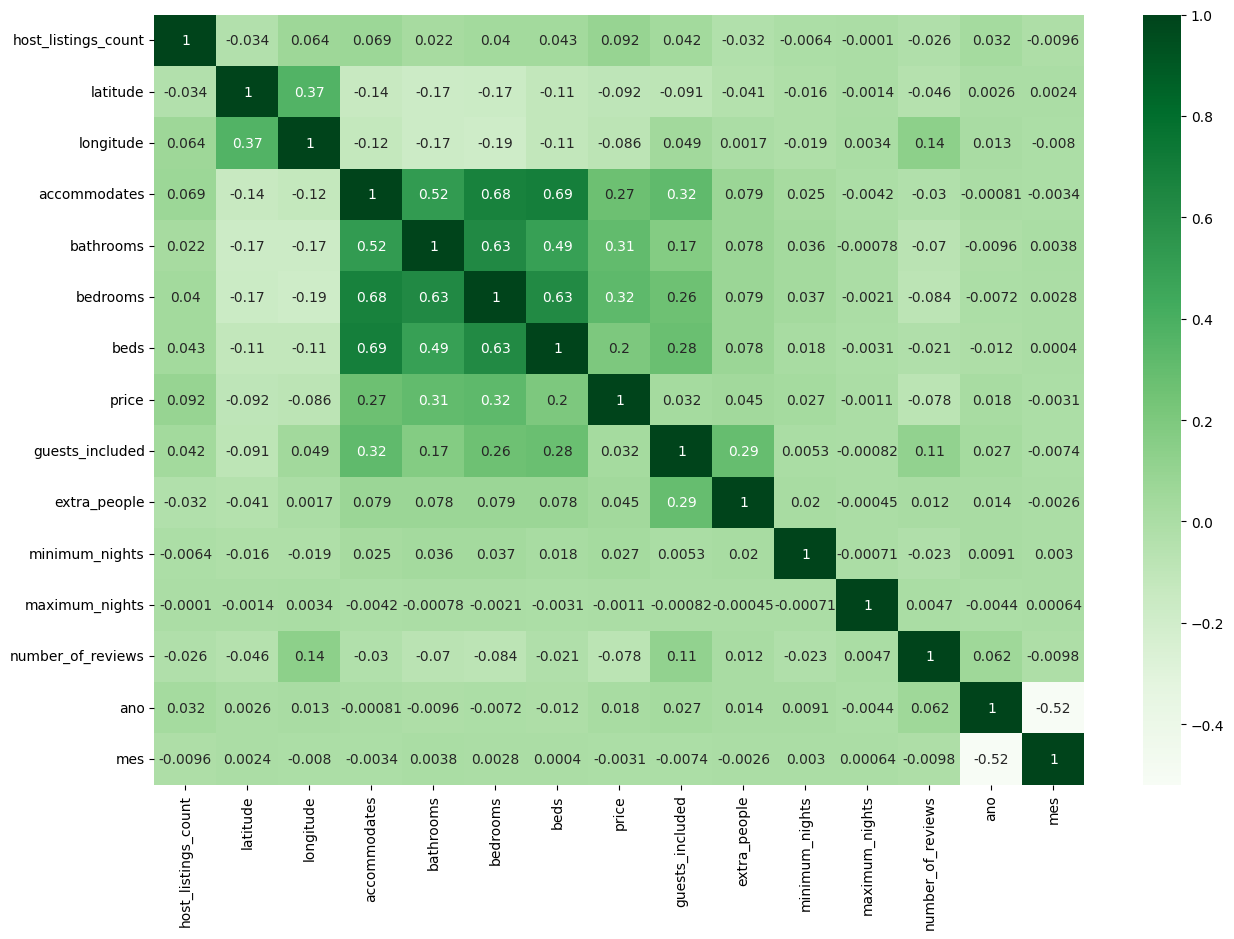

In [106]:
# Select only numeric columns for correlation
numeric_columns = base_airbnb.select_dtypes(include=['number'])

plt.figure(figsize=(15, 10))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='Greens')
plt.show()

### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [107]:
def limites(coluna):
    """
    Calcula os limites inferior e superior para identificação de outliers usando o método do Intervalo Interquartil (IQR).
    
    Parameters:
        coluna (pandas.Series): Série de dados numéricos para calcular os limites de outliers.
        
    Returns:
        tuple: Um par de valores (limite_inferior, limite_superior) onde:
            - limite_inferior: O valor abaixo do qual os dados são considerados outliers (Q1 - 1.5 * IQR)
            - limite_superior: O valor acima do qual os dados são considerados outliers (Q3 + 1.5 * IQR)
    
    Exemplo:
        >>> import pandas as pd
        >>> dados = pd.Series([1, 2, 3, 4, 5, 20, 30])
        >>> lim_inf, lim_sup = limites(dados)
    """
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude


def excluir_outliers(df, nome_coluna):
    """
    Remove linhas de um DataFrame que contêm outliers em uma coluna específica.
    
    Os outliers são determinados usando o método do Intervalo Interquartil (IQR),
    onde valores fora do intervalo [Q1 - 1.5*IQR, Q3 + 1.5*IQR] são considerados outliers.
    
    Parameters:
        df (pandas.DataFrame): DataFrame a ser filtrado.
        nome_coluna (str): Nome da coluna na qual os outliers serão identificados.
        
    Returns:
        tuple: Um par contendo:
            - pandas.DataFrame: O DataFrame filtrado sem os outliers.
            - int: Número de linhas removidas devido a outliers.
    
    """
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [108]:
def diagrama_caixa(coluna):
    """
    Cria dois boxplots lado a lado da mesma coluna, o segundo com limites
    ajustados para melhor visualização de outliers.
    
    Parameters:
        coluna (pandas.Series): Série de dados para visualização em boxplot.
    
    Returns:
        None: Exibe o gráfico, mas não retorna valores.
    
    """
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)


def histograma(coluna):
    """
    Cria um histograma com curva de densidade para visualização da distribuição dos dados.
    
    Parameters:
        coluna (pandas.Series): Série de dados para visualização em histograma.
    
    Returns:
        None: Exibe o gráfico, mas não retorna valores.
    
    """
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna, kde=True)


def grafico_barra(coluna):
    """
    Cria um gráfico de barras mostrando a contagem de valores na coluna,
    com os limites do eixo x ajustados para melhor visualização.
    
    Parameters:
        coluna (pandas.Series): Série de dados para visualização em gráfico de barras.
    
    Returns:
        None: Exibe o gráfico, mas não retorna valores.
    
    """
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Visualização de Outliers

### price

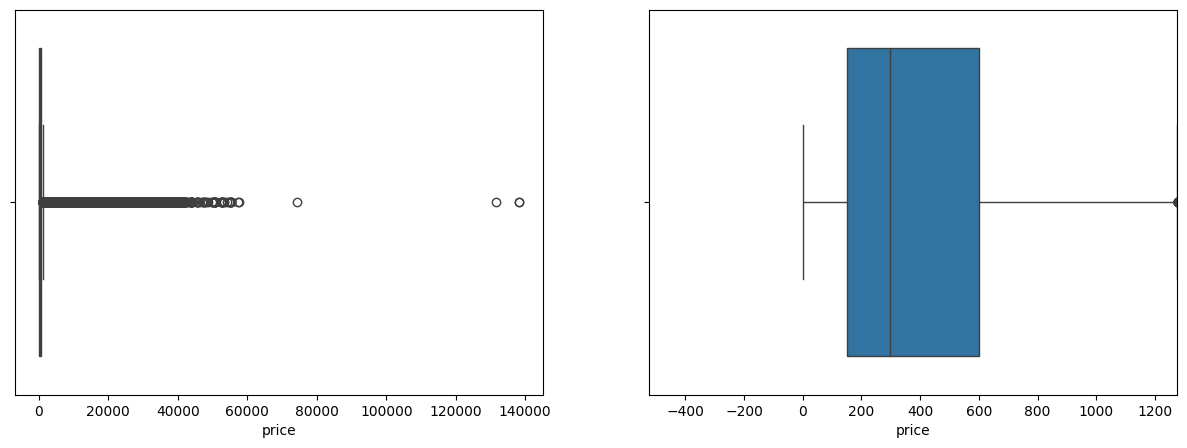

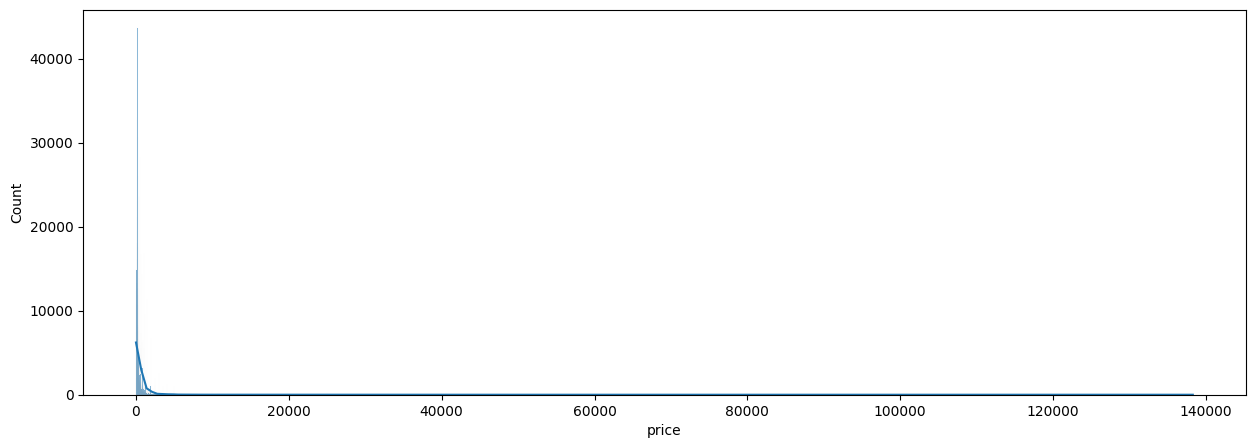

In [109]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [110]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


(810427, 23)


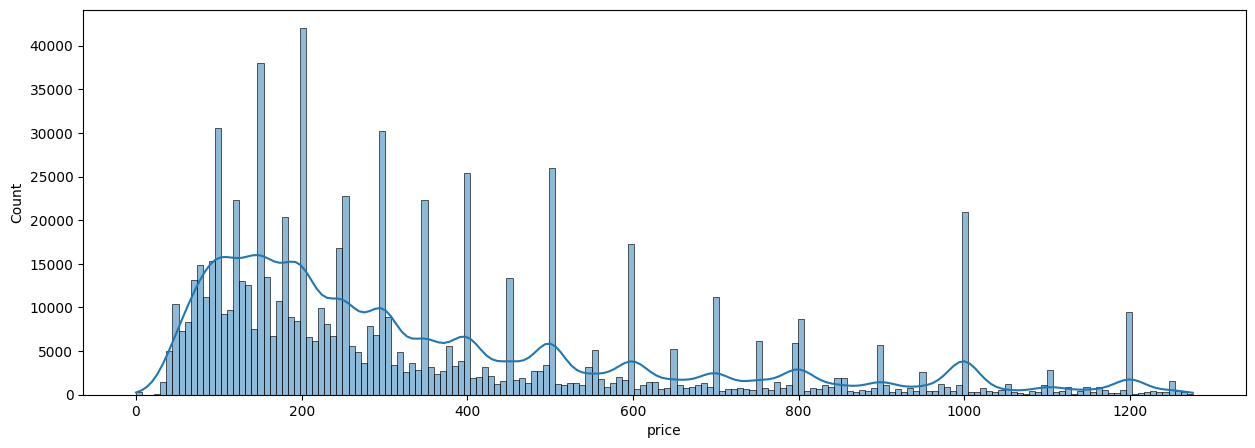

In [111]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### extra_people

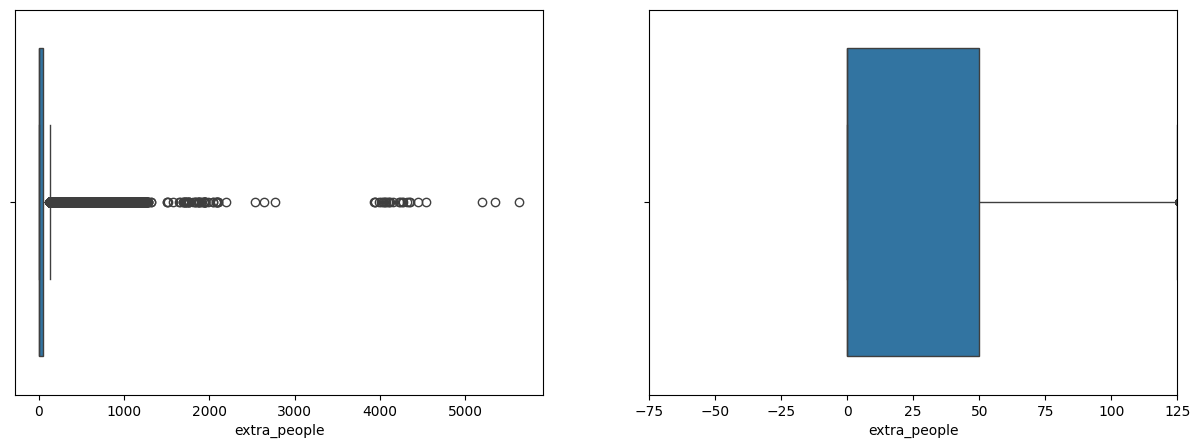

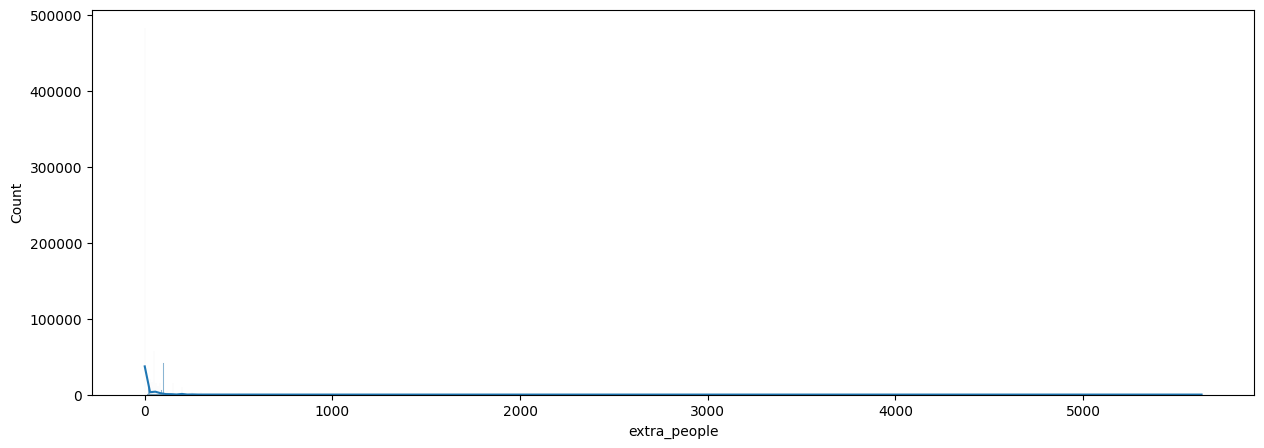

In [112]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [113]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


(751233, 23)


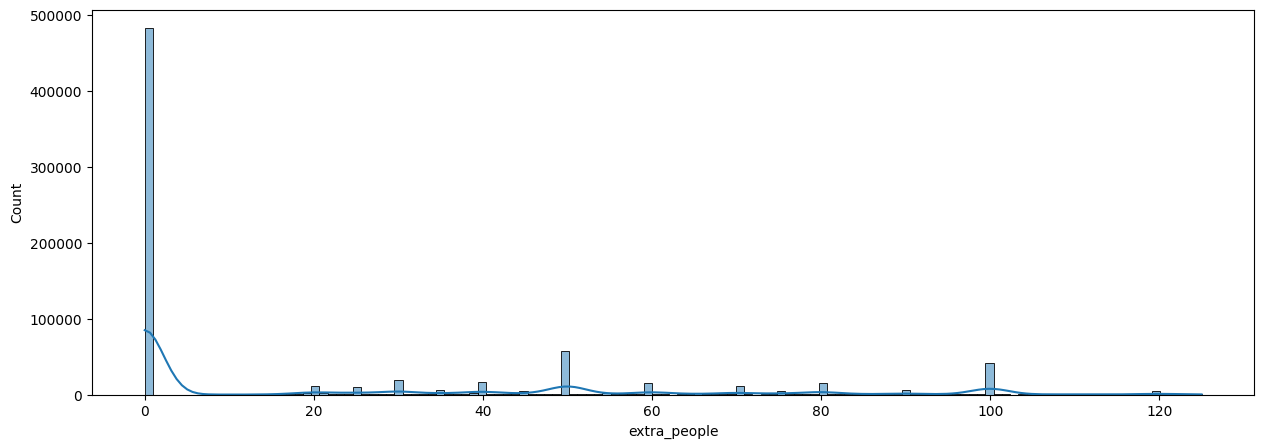

In [114]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### host_listings_count

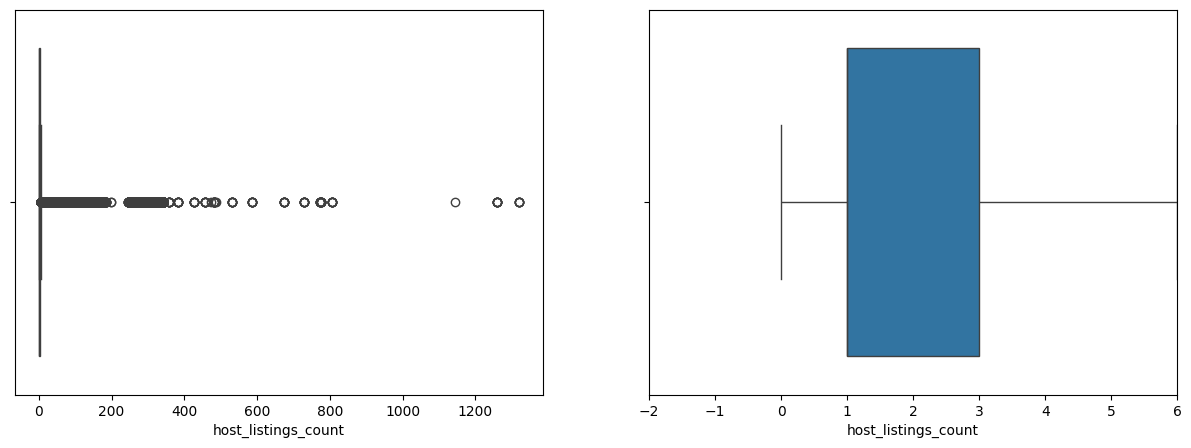

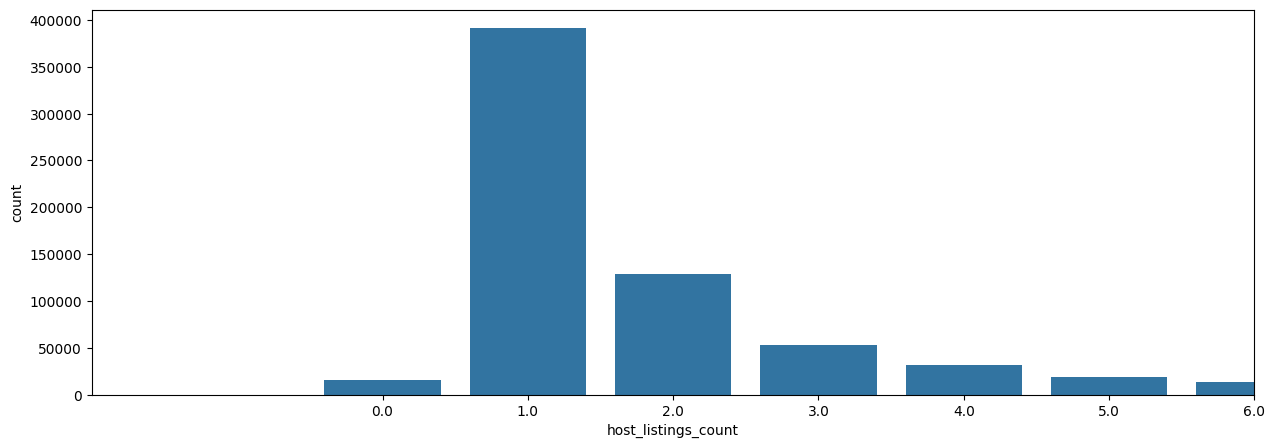

In [115]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto, hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [116]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


### accommodates

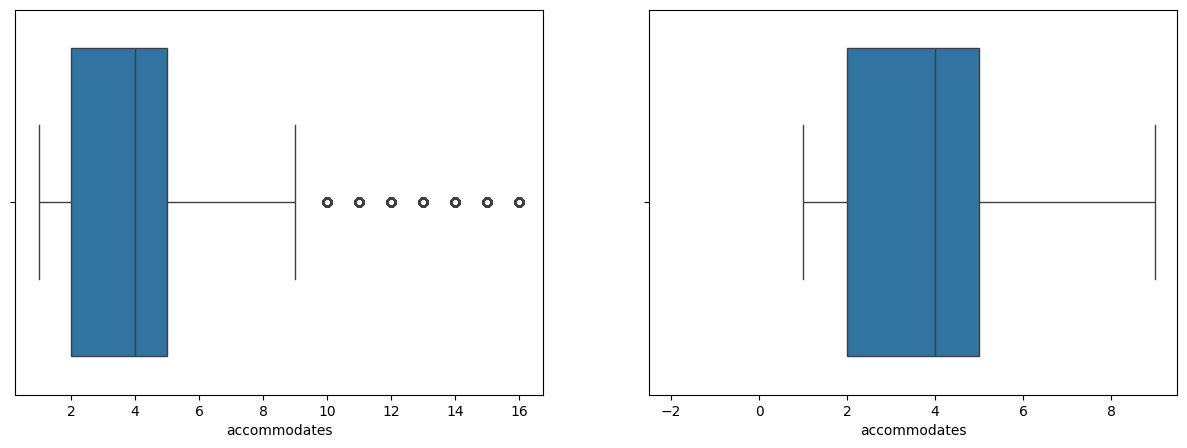

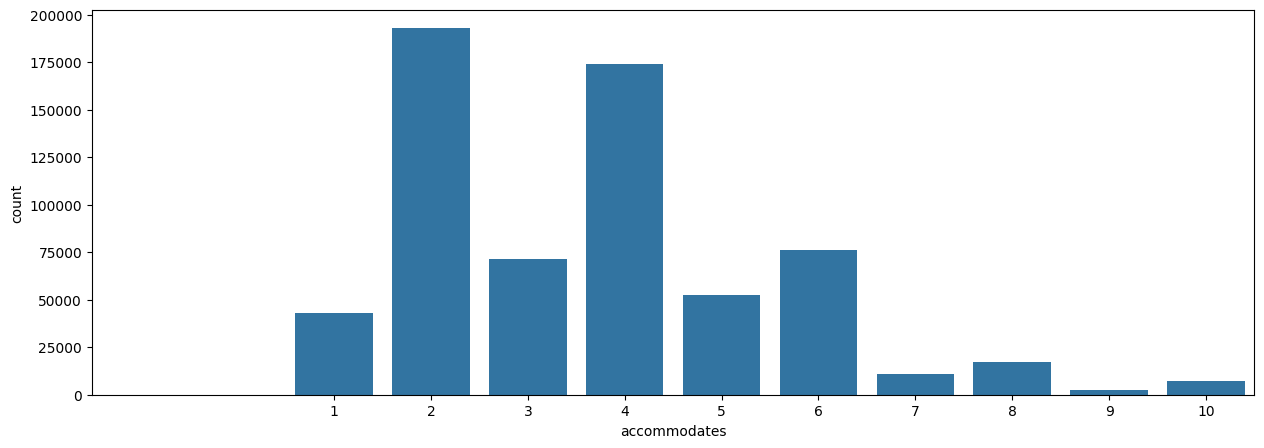

In [117]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

- Pelo mesmo motivo do "host_listings_count" vamos excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

- Caso a gente quisesse incluir apartamentos de alto padrão a gente poderia manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [118]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### bathrooms 

<Axes: xlabel='bathrooms', ylabel='count'>

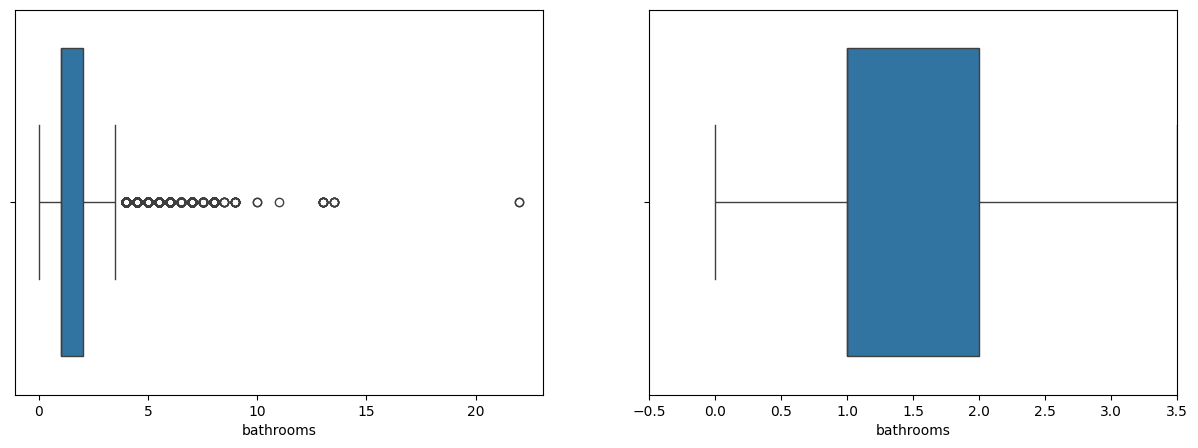

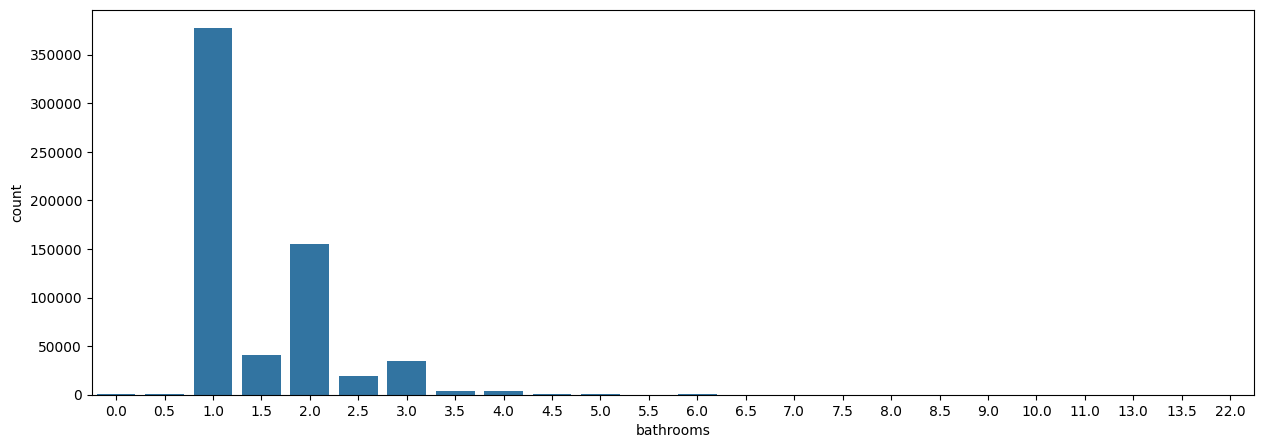

In [119]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

- Pelo mesmo motivo dos anteriores, vamos excluir os outliers nos banheiros

In [120]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### bedrooms

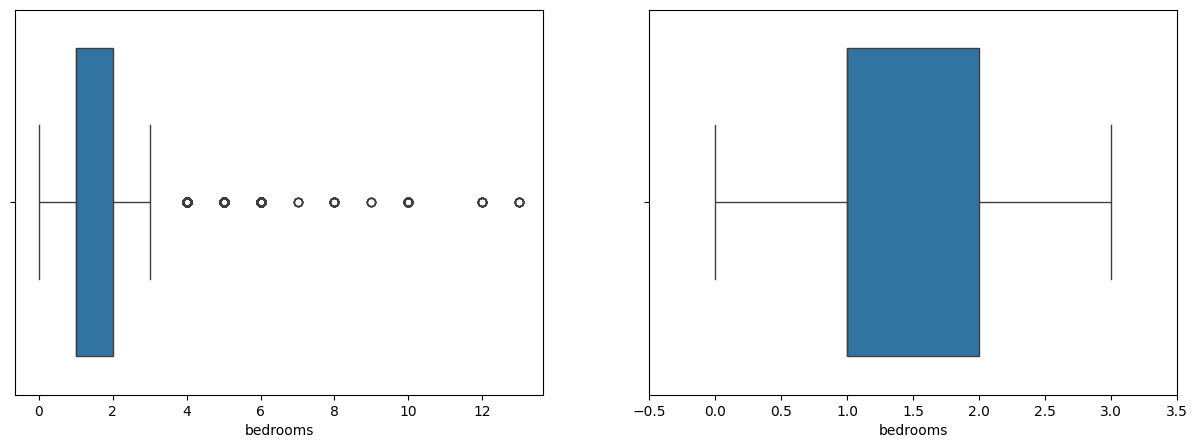

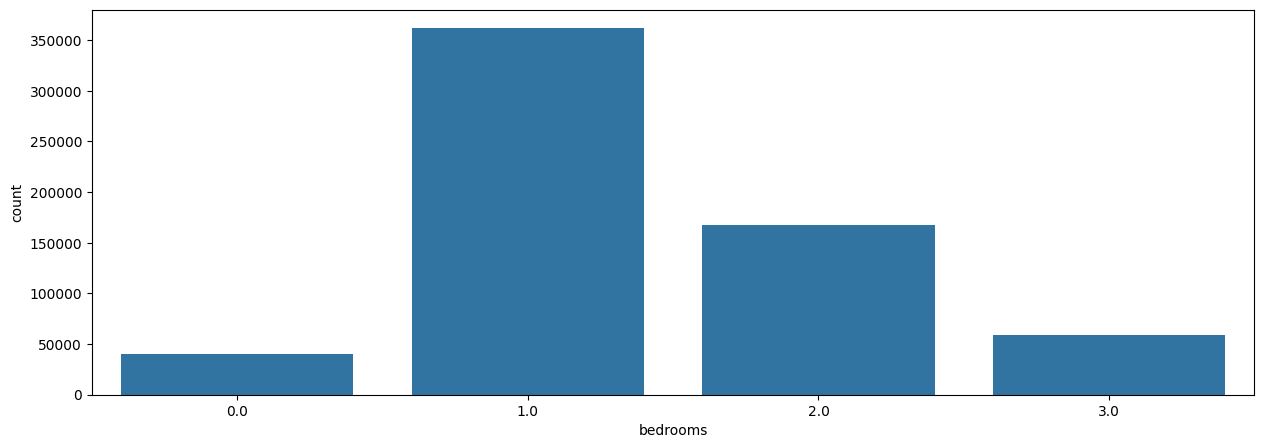

In [121]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de quartos

In [122]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds

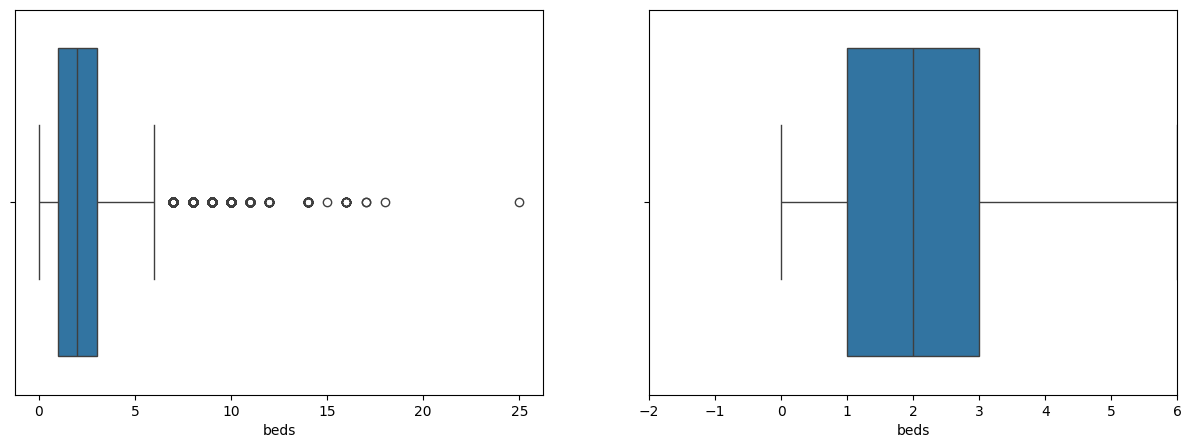

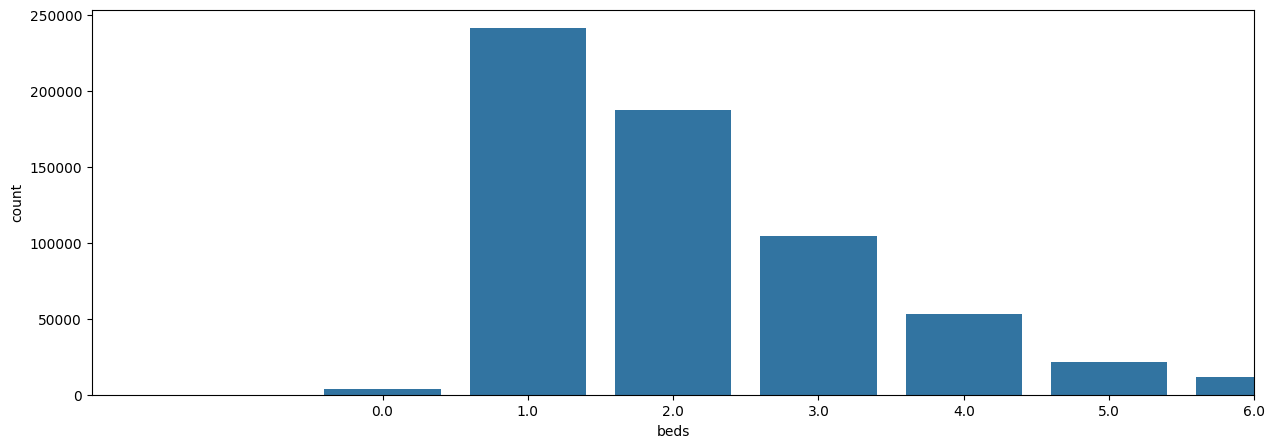

In [123]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de camas

In [124]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### guests_included

C:\Users\dougl\AppData\Local\Temp\ipykernel_3892\3531871458.py:16: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))


(np.float64(1.0), np.float64(1.0))


C:\Users\dougl\AppData\Local\Temp\ipykernel_3892\3531871458.py:49: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(limites(coluna))


<Axes: xlabel='guests_included', ylabel='count'>

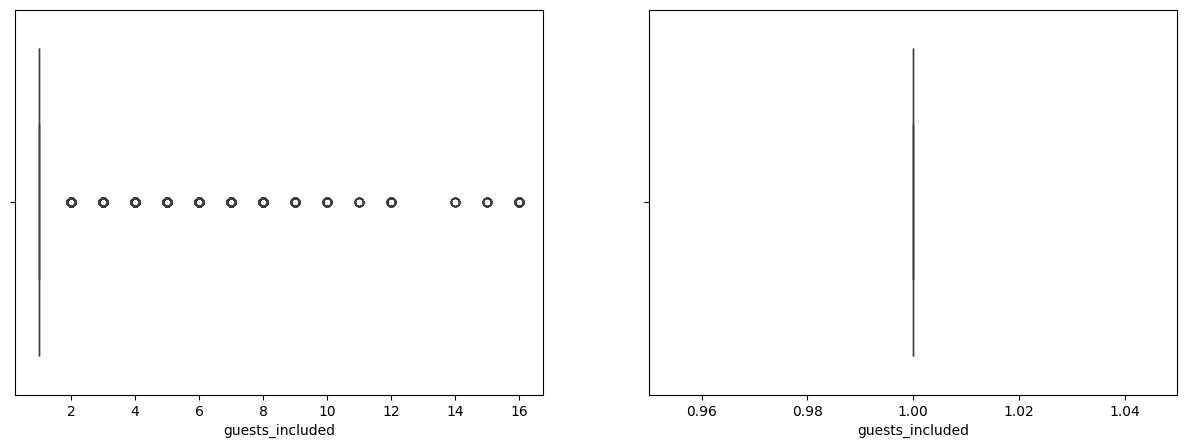

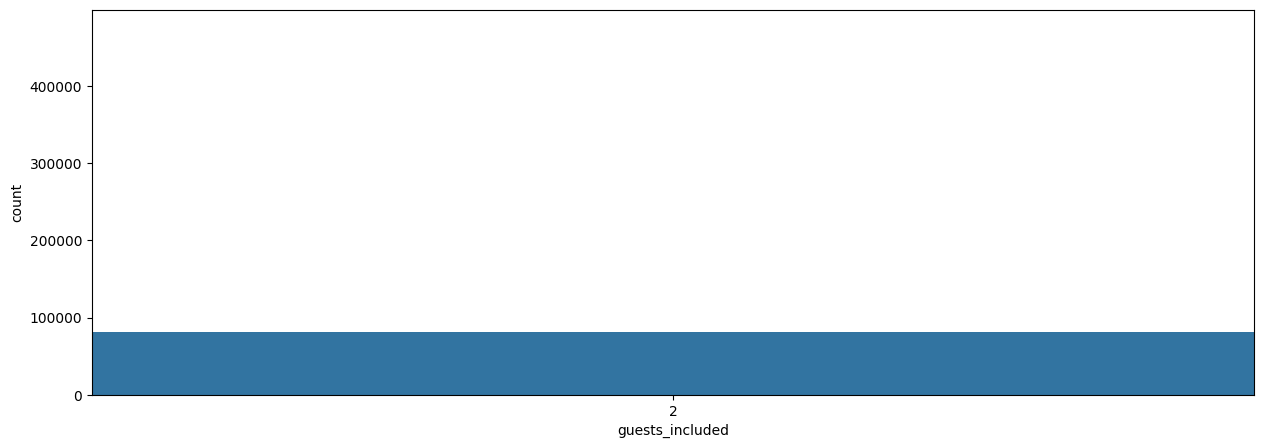

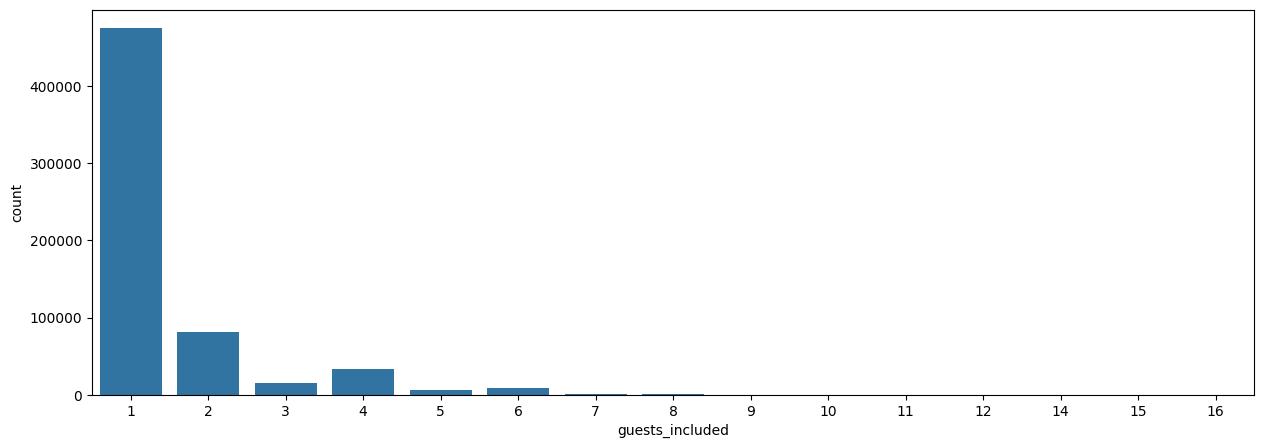

In [125]:
diagrama_caixa(base_airbnb['guests_included'])
grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [126]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

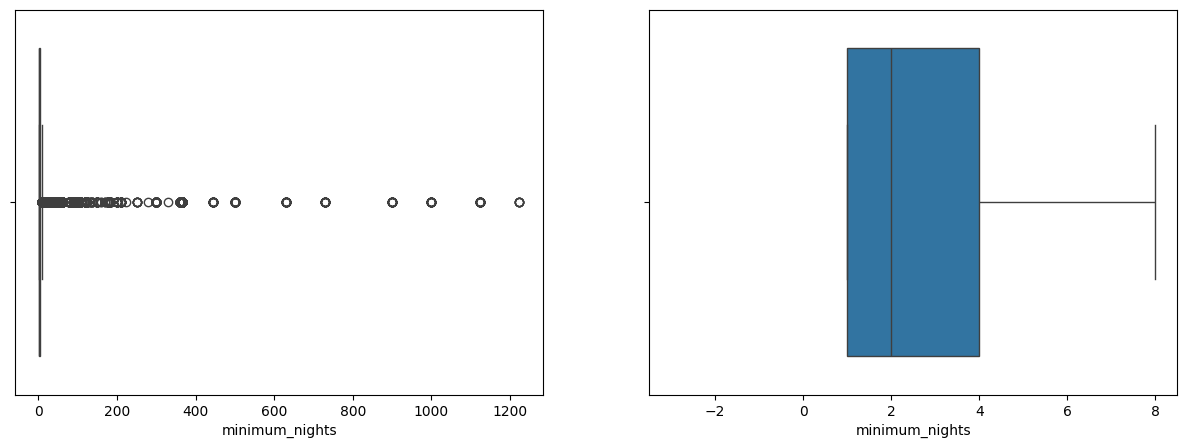

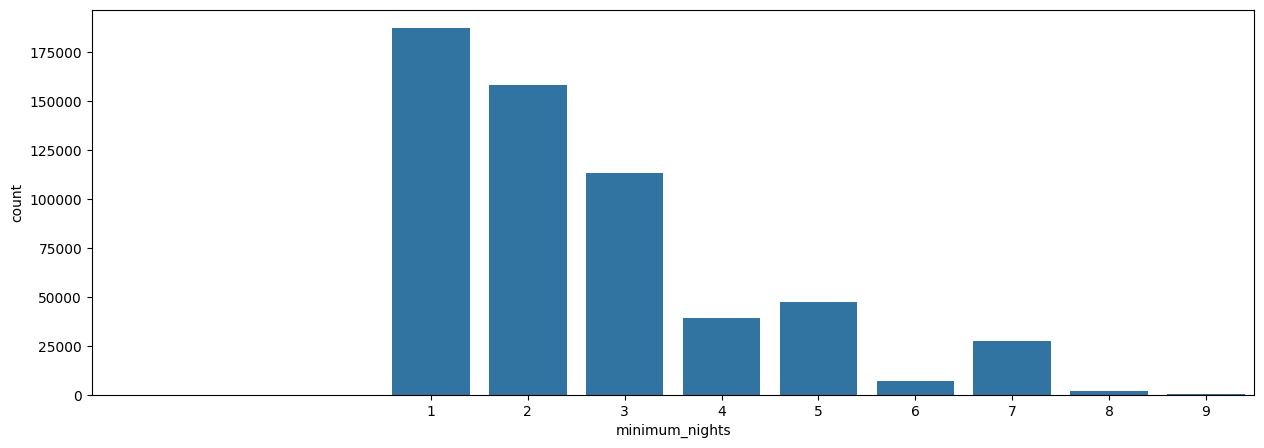

In [127]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [128]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### maximum_nights

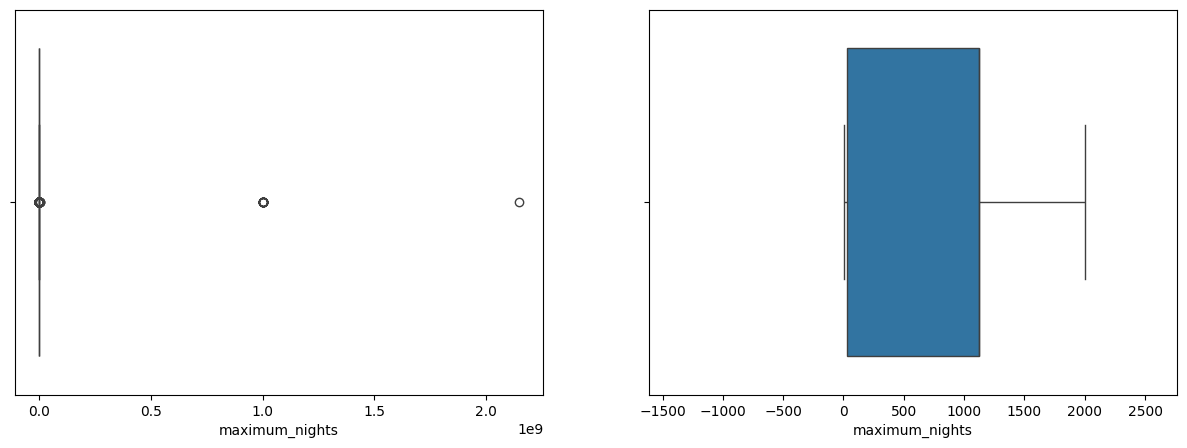

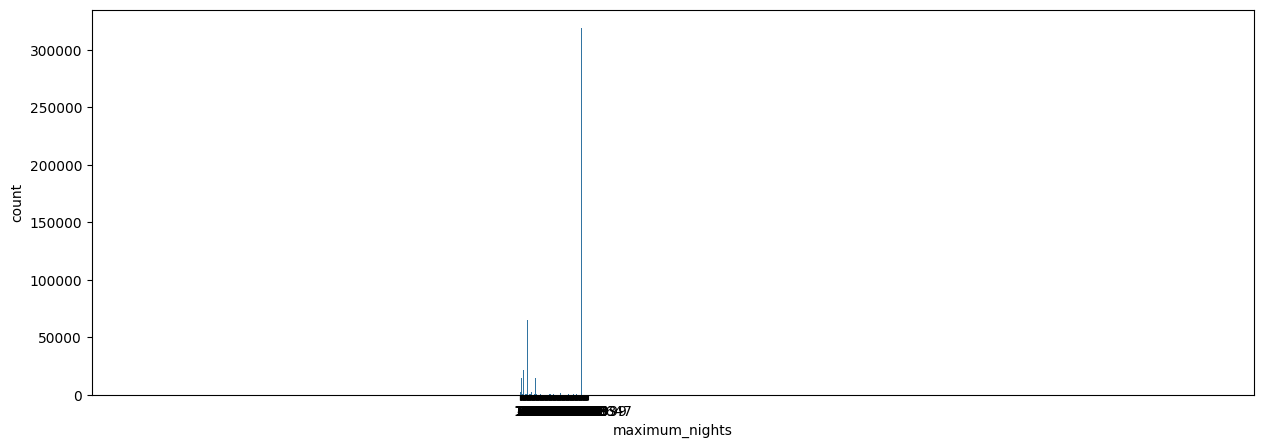

In [129]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

In [130]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews   

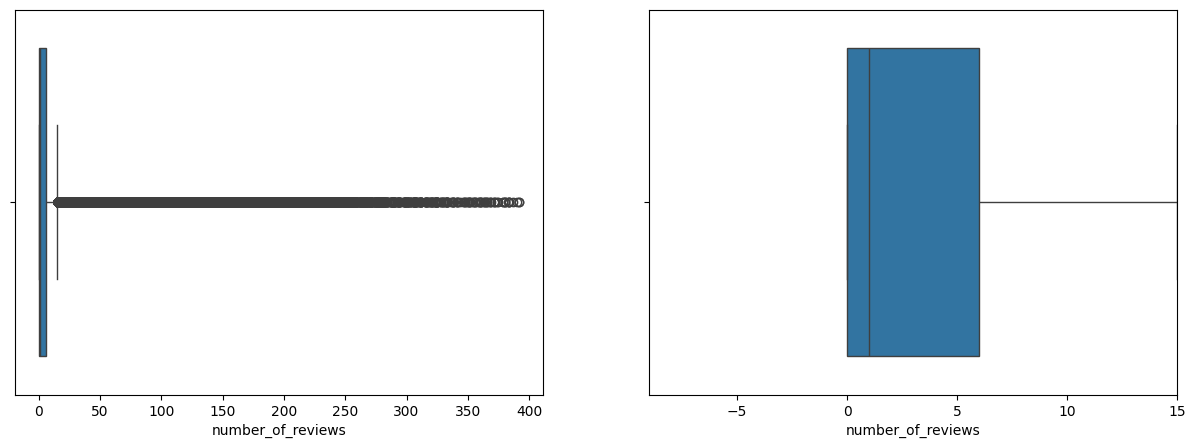

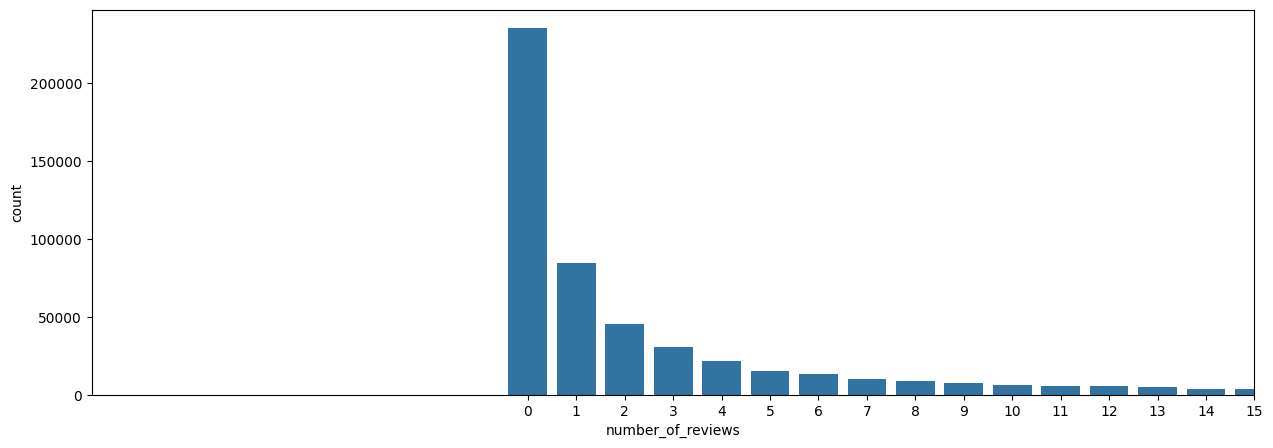

In [131]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou optar por remover essa característica da análise com base em alguns pontos observados:

  1. Se excluirmos os outliers, vamos acabar removendo os hosts com maior número de reviews — justamente os que mais alugam. Isso pode prejudicar o modelo.
  2. Pensando no objetivo do projeto, se estou colocando meu imóvel agora no Airbnb, é natural que ele não tenha nenhum review ainda. Então remover essa variável pode inclusive ajudar na generalização do modelo.
  3. Tenho dúvidas se essa variável deveria realmente influenciar o preço final, então prefiro não incluí-la nesse momento.

In [132]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de Colunas com Valores de Texto

Funções para plotar gráficos e agrupar categorias

In [133]:
def plotar_contagem(coluna):
    """
    Plota um gráfico de contagem para uma coluna especificada no DataFrame base_airbnb.

    Parâmetros:
        coluna (str): O nome da coluna a ser plotada.

    Retorno:
        None: Exibe um gráfico de contagem com a quantidade de cada valor único na coluna especificada.
    """
    plt.figure(figsize=(15, 5))
    sns.countplot(x=coluna, data=base_airbnb, hue=coluna, palette='pastel', legend=False)
    plt.xticks(rotation=90)
    plt.show()

In [134]:
def agrupar_categorias(coluna, limite, nome_agrupado='Outros'):
    """
    Agrupa categorias com menos ocorrências que o limite em 'Outros'
    
    Parâmetros:
    - coluna: Nome da coluna categórica a ser processada
    - limite: Valor mínimo de ocorrências para manter a categoria separada
    - nome_agrupado: Nome para as categorias agrupadas
    """

    contagem = base_airbnb[coluna].value_counts()
    agrupar = [tipo for tipo in contagem.index if contagem[tipo] < limite]

    print(f'Categorias agrupadas: {agrupar}')
    base_airbnb.loc[base_airbnb[coluna].isin(agrupar), coluna] = nome_agrupado

    return base_airbnb[coluna].value_counts()

In [ ]:
print(base_airbnb['property_type'].value_counts())
plotar_contagem('property_type')

- Aqui não vou  "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Todos os tipos de propriedade que têm menos de 2.000 propriedades na base de dados, eu vou agrupar em um grupo chamado "outros". Acho que isso vai facilitar o nosso modelo

In [ ]:
agrupar_categorias('property_type', 2000, 'Outros')

print(base_airbnb['property_type'].value_counts())
plotar_contagem('property_type')

In [ ]:
print(base_airbnb['property_type'].value_counts())
plotar_contagem('property_type')

### - room_type 

In [ ]:
print(base_airbnb['room_type'].value_counts())
plotar_contagem('room_type')

Em tipo de quarto, não precisamos fazer nada, ele já parece estar bem distribuído

### - bed_type 

In [ ]:
print(base_airbnb['bed_type'].value_counts())
plotar_contagem('bed_type')

- Aqui a nossa ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Como temos 1 valor claramente MUITO maior do que todos os outros, vou criar apenas 2 grupos de camas: "Real Bed" e "outros"

Isso vai simplificar o modelo

In [ ]:
agrupar_categorias('bed_type', 10000, 'Outros')
print(base_airbnb['bed_type'].value_counts())
plotar_contagem('bed_type')

### - cancellation_policy 

In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())
plotar_contagem('cancellation_policy')

In [ ]:
agrupar_categorias('cancellation_policy', 10000, 'Outros')
print(base_airbnb['cancellation_policy'].value_counts())
plotar_contagem('cancellation_policy') 

### - amenities 

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [ ]:
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))


Transformação da coluna amenities em valor númerico e exclusão da antiga, assim com nas outras colunas de valores numéricos, eu exclui outliers.

In [ ]:
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

In [ ]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [148]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas
